In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, callbacks
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import tensorflow.keras.backend as K


# Importing and Splitting Data

In [2]:
data = fetch_openml('Kuzushiji-MNIST')

In [3]:
X, t = data.data.to_numpy(), data.target.to_numpy()
X = X/255. # accomplishes the scaling
X = X.reshape((70000,28,28))
t = t.astype(np.uint8)

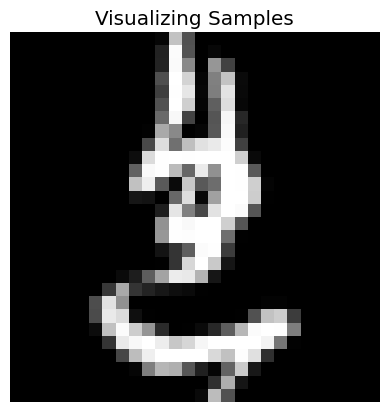

In [4]:
plt.imshow(X[34566], cmap='gray')
plt.axis('off')
plt.title('Visualizing Samples');

In [5]:
X_train, X_test, t_train, t_test = X[:60000], X[60000:], t[:60000], t[60000:]
X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, 
                                                  test_size = 0.20,
                                                  stratify = t_train,
                                                  random_state = 0)

# Tuning Stacked Autoencoder

In [6]:
# Hyperparameters to tune: learning rate, beta values, bottleneck size, 
lr = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.1]
B1 = 0.9
B2 = 0.999
bottleneck = [10, 20, 50, 75, 100, 150]

scores = np.zeros((len(lr), len(bottleneck)))


### Tuning Bottlenck Size and Learning Rate

In [13]:
for ii in range(len(bottleneck)):
    for jj in range(len(lr)):
        encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneck[ii],  activation='relu', use_bias=False)
        ])

        decoder = models.Sequential([
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(28*28, use_bias=False),
            layers.Reshape([28, 28])
        ])

        autoencoder = models.Sequential([encoder, decoder])

        autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                            optimizer=optimizers.Adam(learning_rate=lr[jj],
                            beta_1=B1,
                            beta_2=B2))
        
        callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = autoencoder.fit(X_train, X_train, epochs=50, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1,
                    verbose=0)
        
        scores[jj, ii] = min(history.history['val_loss'])

[[0.0432524  0.03659417 0.02626092 0.01831602 0.0156834  0.01228416]
 [0.04496935 0.04221988 0.02656882 0.02103805 0.01705976 0.01455829]
 [0.05571628 0.04508123 0.03096399 0.03131596 0.0234615  0.02072244]
 [0.06300911 0.06141164 0.05237832 0.05030794 0.04353024 0.04842895]
 [0.10334791 0.15768802 0.1034373  0.06292148 0.06606883 0.06259905]
 [0.15768802 0.15768802 0.08930925 0.0766583  0.07548341 0.08798049]
 [0.15768802 0.15768802 0.15768802 0.15768802 0.1059144  0.15768802]]


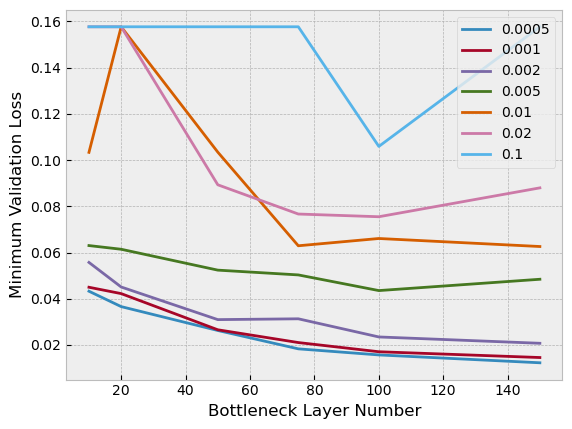

In [ ]:
print(scores)
plt.figure()
plt.plot(bottleneck, scores[0,:])
plt.plot(bottleneck, scores[1,:])
plt.plot(bottleneck, scores[2,:])
plt.plot(bottleneck, scores[3,:])
plt.plot(bottleneck, scores[4,:])
plt.plot(bottleneck, scores[5,:])
plt.plot(bottleneck, scores[6,:])
plt.xlabel('Bottleneck Layer Number')
plt.ylabel('Minimum Validation Loss')
plt.title('Minimum Validation Loss vs. Bottleneck Size')
plt.legend(lr)

Larger bottleneck and smaller learning rate give better performance. 

### Experimenting with Larger Bottleneck Sizes
As expected, since ADAM helps learning overcome small local minimas, the validation loss in image reconstruction decreases with decreasing learning rate, as long as enough training time is given. Somewhat unexpected is how much increasing the number of nodes in the bottleneck layer increases performance. In PCA, to keep 99.9% of the explained variance of each image, only 16 dimensions are needed on average. But we continue to see much better berformance as we increase bottleneck layer nodes up to 150. The lowest value is in the corner of our grid, but for training time purposes, we will keep the learning rate at 0.0005 as lower learning rates may need many more iterations to properly train. We will now check more units in the bottleneck layer to see where we no longer gain extra performance

In [20]:
bottleneckNum  = [125, 150, 200, 250, 300, 350, 400]
scores2 = np.zeros(len(bottleneckNum))
lr = 0.0005

for ii in range(len(bottleneck)):
    
    encoder = models.Sequential([
        layers.Flatten(input_shape=[28,28]),
        layers.Dense(800,  activation='relu', use_bias=False),
        layers.Dense(200,  activation='relu', use_bias=False),
        layers.Dense(bottleneckNum[ii],  activation='relu', use_bias=False)
    ])

    decoder = models.Sequential([
        layers.Dense(200,  activation='relu', use_bias=False),
        layers.Dense(800,  activation='relu', use_bias=False),
        layers.Dense(28*28, use_bias=False),
        layers.Reshape([28, 28])
    ])

    autoencoder = models.Sequential([encoder, decoder])

    autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                        optimizer=optimizers.Adam(learning_rate=lr,
                        beta_1=B1,
                        beta_2=B2))
    
    callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = autoencoder.fit(X_train, X_train, epochs=100, 
                validation_data=(X_val, X_val),
                callbacks=callback1,
                verbose=0)
        
    scores2[ii] = min(history.history['val_loss'])

[0.01213735 0.01158006 0.00972538 0.0102109  0.00936456 0.00923875
 0.00920107]


Text(0, 0.5, 'Minimum Validation Loss')

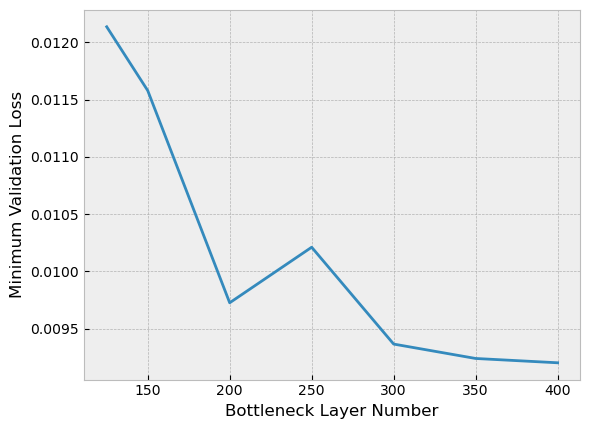

In [21]:
print(scores2)
plt.figure()
plt.plot(bottleneckNum, scores2)
plt.xlabel('Bottleneck Size')
plt.ylabel('Validation MSE')
plt.title('Loss vs. Bottleneck Size');

### Tuning Optimizer

In [7]:
# Tune the beta hyperparameters for adam to possibly increase convergence rate. Beta values need to be less than 1
bottleneckNum  = 200

lr = 0.0005
B1 = [0.85, 0.875, 0.9, 0.925, 0.95]
B2 = [0.995, 0.996, 0.997, 0.998, 0.999]
scores2 = np.zeros((len(B1),len(B2)))
numIter = np.zeros((len(B1),len(B2)))

encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneckNum,  activation='relu', use_bias=False)
        ])

decoder = models.Sequential([
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(28*28, use_bias=False),
            layers.Reshape([28, 28])
        ])

autoencoder = models.Sequential([encoder, decoder])

callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for ii in range(len(B1)):
    
    for jj in range(len(B2)):
        
        K.clear_session()
    
        
        autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                            optimizer=optimizers.Adam(learning_rate=lr,
                            beta_1=B1[ii],
                            beta_2=B2[jj]))
        
        

        history = autoencoder.fit(X_train, X_train, epochs=100, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1,
                    verbose=0)
             
        scores2[ii, jj] = min(history.history['val_loss'])
        numIter[ii, jj] = len(history.history['val_loss'])
        
        print(5*ii+jj+1)

1


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
print(scores2.shape)
print(np.argmin(scores2))

print('Lowest Val loss was with beta 1 = ', B1[2], ' and beta 2 = ', B2[2])

fig, ax = plt.subplots()
im = ax.imshow(scores2)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(B2)), labels=B2)
ax.set_yticks(np.arange(len(B1)), labels=B1)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(B1)):
    for j in range(len(B2)):
        text = ax.text(j, i, scores2[i, j],
                       ha="center", va="center", color="w")

(7, 5)
12
Lowest Val loss was with beta 1 =  0.875  and beta 2 =  0.997


### Training Final SAE

In [27]:
# Train Final Base SAE
bottleneckNum  = 200
lr = 0.0005
B1 = 0.875
B2 = 0.997

encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneckNum,  activation='relu', use_bias=False)
        ])

decoder = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                    optimizer=optimizers.Adam(learning_rate=lr,
                    beta_1=B1,
                    beta_2=B2))

callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

historySAE = autoencoder.fit(X_train, X_train, epochs=100, 
            validation_data=(X_val, X_val),
            callbacks=callback1,
            verbose=1)

Epoch 1/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0370 - val_loss: 0.0249
Epoch 2/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0228 - val_loss: 0.0211
Epoch 3/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0201 - val_loss: 0.0192
Epoch 4/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0187 - val_loss: 0.0179
Epoch 5/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 6/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 7/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0165 - val_loss: 0.0161
Epoch 8/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0161 - val_loss: 0.0159
Epoch 9/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 10/100
1500/1500 [==============================] - 2s 1ms/step - l

In [ ]:
# Evaluation
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
# Save the model weights
autoencoder.save_weights('SAE_weights.h5')
encoder.save_weights('SAE_encoder_weights.h5')
decoder.save_weights('SAE_decoder_weights.h5')

### Loading Trained Model

In [6]:
bottleneck = 200

encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneck,  activation='relu', use_bias=False)
        ])

decoder = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

autoencoder = models.Sequential([encoder, decoder])

In [7]:
autoencoder.load_weights('SAE_weights.h5')
encoder = autoencoder.layers[0]
decoder = autoencoder.layers[1]

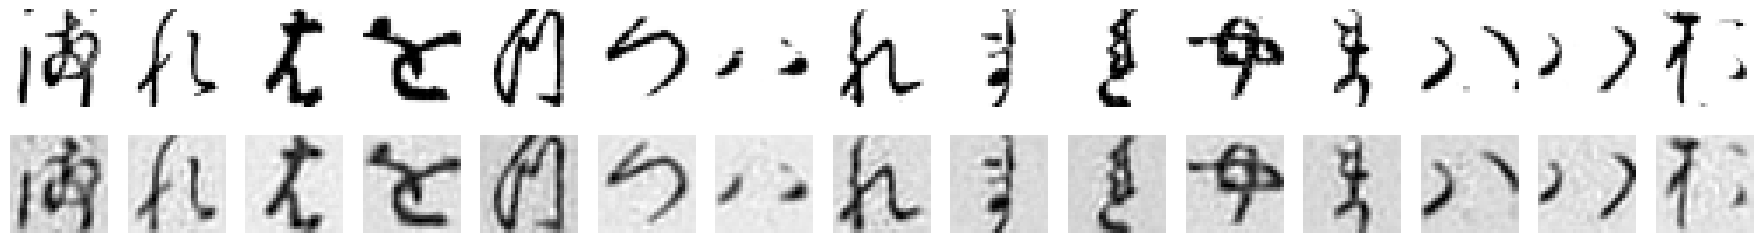

In [8]:
# visualize images reconstructed from encodings
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

def show_reconstructions(model, n_images=15):
    reconstructions = model.predict(X_val[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_val[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(autoencoder)

The reconstructions look really good!!

# Training a Classifier on Encoded Data

### Encoding Data

In [9]:
codings_train = encoder.predict(X_train)
codings_val = encoder.predict(X_val)
codings_test = encoder.predict(X_test)

### Single-Layer MLP

In [10]:
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
patience = 10
epochs = 500

optimizer = optimizers.Nadam(learning_rate = learning_rate, 
                                   beta_1 = beta_1, beta_2 = beta_2)

callback = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = patience,
                                         restore_best_weights = True)

In [13]:
N1_vals = [64, 128, 256, 512, 1024]

test_performance = np.zeros((len(N1_vals), 2))

In [14]:
for N1_idx, N1 in np.ndenumerate(N1_vals):
    print('Training NN of size:', N1)

    classifier = models.Sequential([
        layers.Input(shape=(bottleneck,)),
        layers.Dense(N1, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ])
    
    classifier.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])
    
    history = classifier.fit(codings_train, t_train, epochs = epochs,
                        batch_size = 1024,
                        validation_data = (codings_val, t_val),
                        callbacks = [callback],
                        verbose=0)
    
    test_performance[N1_idx, :] = classifier.evaluate(codings_test, t_test)
    
    clear_output()

In [15]:
print(test_performance)

[[0.69306099 0.79509997]
 [0.52983433 0.84909999]
 [0.47145656 0.87080002]
 [0.40957028 0.8876    ]
 [0.40118203 0.889     ]]


The larger the layer the size, the greater the performance.

### Double-Layer MLP

In [16]:
epochs = 200
N1 = 1024
N2_vals = [64, 128, 256, 512, 1024]

test_performance = np.zeros((len(N2_vals), 2))

In [17]:
for N2_idx, N2 in np.ndenumerate(N2_vals):
    print('Training NN of size:', (N1, N2))

    classifier = models.Sequential([
        layers.Input(shape=(bottleneck,)),
        layers.Dense(N1, activation = 'relu'),
        layers.Dense(N2, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ])
    
    classifier.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])
    
    history = classifier.fit(codings_train, t_train, epochs = epochs,
                        batch_size = 1024,
                        validation_data = (codings_val, t_val),
                        callbacks = [callback],
                        verbose=0)
    
    test_performance[N2_idx, :] = classifier.evaluate(codings_test, t_test)
    
    clear_output()

In [18]:
print(test_performance)

[[0.56097078 0.8513    ]
 [0.49606895 0.86760002]
 [0.46907485 0.86430001]
 [0.49632621 0.86500001]
 [0.46472082 0.8786    ]]


Adding a second layer improved performance overall. However, increasing the size of the second layer did not guarantee better performance, as was seen with the first layer.

In [19]:
N1_vals = [64, 128, 256, 512, 1024]
N2_vals = [64, 128, 256, 512, 1024]

test_performance = np.zeros((len(N1_vals), len(N2_vals), 2))

In [20]:
for N1_idx, N1 in np.ndenumerate(N1_vals):
    for N2_idx, N2 in np.ndenumerate(N2_vals):
        print('Training NN of size:', (N1, N2))

        classifier = models.Sequential([
            layers.Input(shape=(bottleneck,)),
            layers.Dense(N1, activation = 'relu'),
            layers.Dense(N2, activation = 'relu'),
            layers.Dense(10, activation = 'softmax')
        ])

        classifier.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                 metrics = ['accuracy'])

        history = classifier.fit(codings_train, t_train, epochs = epochs,
                            batch_size = 2048,
                            validation_data = (codings_val, t_val),
                            callbacks = [callback],
                            verbose=0)

        test_performance[N1_idx, N2_idx, :] = classifier.evaluate(codings_test, t_test)

        clear_output()

In [21]:
print(test_performance)

[[[0.58347702 0.8337    ]
  [0.51242405 0.85430002]
  [0.48024291 0.86849999]
  [0.44932598 0.87639999]
  [0.4170084  0.88679999]]

 [[0.51231533 0.85189998]
  [0.50795412 0.8678    ]
  [0.4568212  0.88050002]
  [0.4378964  0.88090003]
  [0.41650507 0.88300002]]

 [[0.53988385 0.84210002]
  [0.49122089 0.866     ]
  [0.47877076 0.86879998]
  [0.42064479 0.88669997]
  [0.44122115 0.88639998]]

 [[0.55441523 0.84460002]
  [0.48095453 0.87050003]
  [0.4436374  0.87840003]
  [0.47862399 0.86629999]
  [0.4701212  0.87529999]]

 [[0.51473349 0.84960002]
  [0.47921774 0.86729997]
  [0.47208726 0.86930001]
  [0.477281   0.86949998]
  [0.47461885 0.87159997]]]


The classifier performed best with layers of size 1024-256.

### Triple-Layer MLP

In [30]:
epochs = 500
N1 = 1024
N2 = 512
N3_vals = [64, 128, 256, 512]

test_performance = np.zeros((len(N3_vals), 2))

In [31]:
for N3_idx, N3 in np.ndenumerate(N3_vals):
    print('Training NN of size:', (N1, N2, N3))

    classifier = models.Sequential([
        layers.Input(shape=(bottleneck,)),
        layers.Dense(N1, activation = 'relu'),
        layers.Dense(N2, activation = 'relu'),
        layers.Dense(N3, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ])
    
    classifier.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])
    
    history = classifier.fit(codings_train, t_train, epochs = epochs,
                        batch_size = 1024,
                        validation_data = (codings_val, t_val),
                        callbacks = [callback],
                        verbose=0)
    
    test_performance[N3_idx, :] = classifier.evaluate(codings_test, t_test)
    
    clear_output()

In [32]:
print(test_performance)

[[0.50864476 0.86589998]
 [0.48213008 0.86760002]
 [0.485154   0.86860001]
 [0.4636021  0.88279998]]


The classifier performed best with size 1024-256-32. 

Multiple layers were experimented with, but the best performing model was still the single layer MLP with 1024 nodes.

### Trying a Single Layer Again

In [33]:
N1_vals = [1024, 2048, 4096]

test_performance = np.zeros((len(N1_vals), 2))

In [35]:
for N1_idx, N1 in np.ndenumerate(N1_vals):
    print('Training NN of size:', N1)

    classifier = models.Sequential([
        layers.Input(shape=(bottleneck,)),
        layers.Dense(N1, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ])
    
    classifier.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])
    
    history = classifier.fit(codings_train, t_train, epochs = epochs,
                        batch_size = 1024,
                        validation_data = (codings_val, t_val),
                        callbacks = [callback],
                        verbose=0)
    
    test_performance[N1_idx, :] = classifier.evaluate(codings_test, t_test)
    
    clear_output()

In [36]:
print(test_performance)

[[0.38700962 0.89289999]
 [0.36684039 0.89999998]
 [0.39712453 0.88749999]]


To me, it seems that a single layer gets the job done and performs comparably, if not better, to the deeper MLPs. This last run also seems to suggest that, beyond a certain number, increasing the size of that layer doesn't make meaningful improvements to performance. 

Our MLP from Project 1 was getting a training accuracy of 89.52%. Encoding the training data hasn't seem to have had a significant effect on model performance. I suppose this is good, as training times are lower than before.

### Training and Evaluating Final Codings Classifier

In [ ]:
classifier = models.Sequential([
    layers.Input(shape=(bottleneck,)),
    layers.Dense(1024, activation = 'sigmoid'),
    layers.Dense(10, activation = 'softmax')
])

classifier.compile(loss = 'sparse_categorical_crossentropy',
         optimizer = optimizer,
         metrics = ['accuracy'])

history = classifier.fit(codings_train, t_train, epochs = epochs,
                    batch_size = 1024,
                    validation_data = (codings_val, t_val),
                    callbacks = [callback],
                    verbose=0)

Epoch 1/500
47/47 [==============================] - 1s 8ms/step - loss: 2.0509 - accuracy: 0.3716 - val_loss: 1.7510 - val_accuracy: 0.5642
Epoch 2/500
47/47 [==============================] - 0s 6ms/step - loss: 1.5165 - accuracy: 0.6476 - val_loss: 1.3207 - val_accuracy: 0.6785
Epoch 3/500
47/47 [==============================] - 0s 6ms/step - loss: 1.1906 - accuracy: 0.6973 - val_loss: 1.0791 - val_accuracy: 0.7210
Epoch 4/500
47/47 [==============================] - 0s 6ms/step - loss: 1.0049 - accuracy: 0.7295 - val_loss: 0.9551 - val_accuracy: 0.7287
Epoch 5/500
47/47 [==============================] - 0s 6ms/step - loss: 0.8954 - accuracy: 0.7500 - val_loss: 0.8492 - val_accuracy: 0.7650
Epoch 6/500
47/47 [==============================] - 0s 6ms/step - loss: 0.8266 - accuracy: 0.7650 - val_loss: 0.8074 - val_accuracy: 0.7688
Epoch 7/500
47/47 [==============================] - 0s 6ms/step - loss: 0.7810 - accuracy: 0.7751 - val_loss: 0.7519 - val_accuracy: 0.7815
Epoch 8/500
4

In [14]:
y_proba_train = classifier.predict(codings_train)
y_proba_test = classifier.predict(codings_test)
y_train = np.argmax(y_proba_train, axis=1)
y_test = np.argmax(y_proba_test, axis=1)

Performance in training:
1500/1500 [==============================] - 1s 832us/step - loss: 0.0396 - accuracy: 0.9927


[0.03956827148795128, 0.9927083253860474]

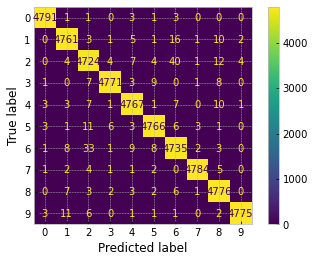

In [15]:
print('Performance in training:')
conf_mx = confusion_matrix(t_train, y_train)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
classifier.evaluate(codings_train, t_train)

Performance in test:
313/313 [==============================] - 0s 637us/step - loss: 0.3442 - accuracy: 0.9045


[0.34420591592788696, 0.9045000076293945]

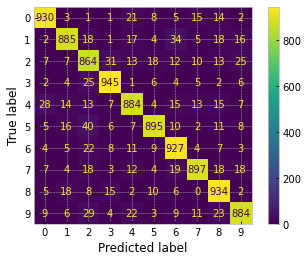

In [16]:
print('Performance in test:')
conf_mx = confusion_matrix(t_test, y_test)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
classifier.evaluate(codings_test, t_test)

# Using SAE to Generate New Images

In [17]:
# sets apart a set of codings and labels with one from each class
other_condings, codings, other_labels, labels = train_test_split(codings_train, t_train, 
                                                  test_size = 10, # take ten samples
                                                  stratify = t_train, # t_train is evenly distributed in classes
                                                  random_state = 0)

In [18]:
def generate_images(codings, labels, stddev, decoder):
    '''give it a set of codings, one from each class, and it will make 1,000 new samples and their labels'''
    new_codings = codings
    new_labels = labels
    for i in np.arange(99): # this loop just copies the codings and labels enough to get 1000 samples
        new_codings = np.vstack((new_codings, codings))
        new_labels = np.hstack((new_labels, labels))
    noise = tf.random.normal(shape=tf.shape(new_codings), mean=0, stddev=stddev) # generate noise
    noisy_codings = new_codings + noise # add noise to codings
    new_images = decoder.predict(noisy_codings) # generate images from noisy codings
    return new_images, new_labels

In [101]:
new_images, new_labels = generate_images(codings, labels, 0.2, decoder)

Class: 6


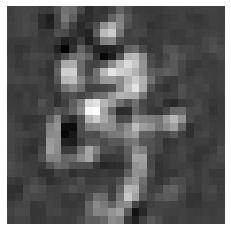

In [102]:
idx = 262
print('Class:', new_labels[idx])
plt.figure()
plt.imshow(new_images[idx], cmap='gray')
plt.axis('off');

### Project 1 Classifier Performance as a Function of Noise Variance

In [103]:
callback = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 10,
                                         restore_best_weights = True)

optimizer = optimizers.Nadam(learning_rate = 0.001, 
                                   beta_1 = 0.9, beta_2 = 0.999)

Project1Classifier = models.Sequential([
    layers.Input(shape=(28,28)),
    layers.Flatten(),
    layers.Dense(256, activation = 'sigmoid'),
    layers.Dense(10, activation = 'sigmoid')
])

Project1Classifier.compile(loss = 'sparse_categorical_crossentropy',
         optimizer = optimizer,
         metrics = ['accuracy'])

history = Project1Classifier.fit(X_train, t_train, epochs = 500,
                    batch_size = 1024,
                    validation_data = (X_val, t_val),
                    callbacks = [callback])

Epoch 1/500
47/47 [==============================] - 1s 7ms/step - loss: 1.4240 - accuracy: 0.6303 - val_loss: 0.9209 - val_accuracy: 0.7598
Epoch 2/500
47/47 [==============================] - 0s 5ms/step - loss: 0.7943 - accuracy: 0.7849 - val_loss: 0.7060 - val_accuracy: 0.8012
Epoch 3/500
47/47 [==============================] - 0s 6ms/step - loss: 0.6594 - accuracy: 0.8131 - val_loss: 0.6214 - val_accuracy: 0.8201
Epoch 4/500
47/47 [==============================] - 0s 5ms/step - loss: 0.5926 - accuracy: 0.8280 - val_loss: 0.5712 - val_accuracy: 0.8315
Epoch 5/500
47/47 [==============================] - 0s 5ms/step - loss: 0.5444 - accuracy: 0.8405 - val_loss: 0.5295 - val_accuracy: 0.8429
Epoch 6/500
47/47 [==============================] - 0s 5ms/step - loss: 0.5035 - accuracy: 0.8518 - val_loss: 0.4939 - val_accuracy: 0.8539
Epoch 7/500
47/47 [==============================] - 0s 6ms/step - loss: 0.4675 - accuracy: 0.8626 - val_loss: 0.4616 - val_accuracy: 0.8633
Epoch 8/500
4

In [104]:
y_proba = Project1Classifier.predict(new_images)
y = np.argmax(y_proba, axis=1)

Performance of Project 1 classifier with stddev=0.2:
32/32 [==============================] - 0s 604us/step - loss: 0.5536 - accuracy: 0.8290


[0.5535561442375183, 0.8289999961853027]

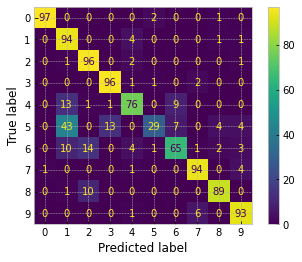

In [105]:
print('Performance of Project 1 classifier on new images with stddev=0.2:')
conf_mx = confusion_matrix(new_labels, y)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
Project1Classifier.evaluate(new_images, new_labels)

Decent performance, but struggles with classes 5 and 6.

Class 5 and 6:


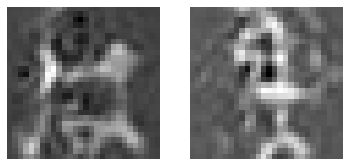

In [ ]:
print('Class 5 and 6:' )
plt.figure()
plt.subplot(1,2,1)
plt.imshow(new_images[254], cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(new_images[252], cmap='gray')
plt.axis('off')

In [107]:
new_images, new_labels = generate_images(codings, labels, 0.5, decoder)

In [108]:
y_proba = Project1Classifier.predict(new_images)
y = np.argmax(y_proba, axis=1)

Performance of Project 1 classifier with stddev=0.5:
32/32 [==============================] - 0s 628us/step - loss: 2.8900 - accuracy: 0.3850


[2.889953851699829, 0.38499999046325684]

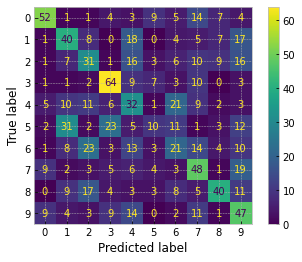

In [109]:
print('Performance of Project 1 classifier on new images with stddev=0.5:')
conf_mx = confusion_matrix(new_labels, y)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
Project1Classifier.evaluate(new_images, new_labels)

More noise made for much worse performance.

In [110]:
stddev_vals = np.linspace(0, 2, 51)
accuracy = np.zeros((len(stddev_vals),2))

In [111]:
for idx, stddev in np.ndenumerate(stddev_vals):
    new_images, new_labels = generate_images(codings, labels, stddev, decoder)
    accuracy[idx,:] = Project1Classifier.evaluate(new_images, new_labels)

32/32 [==============================] - 0s 568us/step - loss: 4.6881 - accuracy: 0.1790


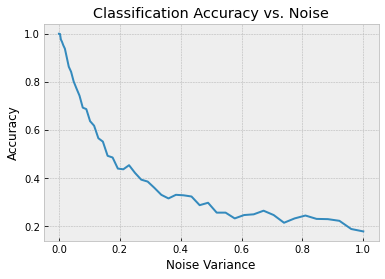

In [112]:
plt.figure()
plt.plot(stddev_vals**2, accuracy[:,1])
plt.xlabel('Noise Variance')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy vs. Noise');

### Adding Noisy Images to Training Data

In [113]:
new_images, new_labels = generate_images(codings, labels, 0.2, decoder)

In [114]:
noisy_train = np.vstack((X_train, new_images))
noisy_labels = np.hstack((t_train, new_labels))

In [115]:
noisy_train, noisy_val, noisy_labels, noisy_val_labels = train_test_split(noisy_train, noisy_labels, 
                                                  test_size = 0.20,
                                                  stratify = noisy_labels,
                                                  random_state = 0)

In [116]:
Project1Classifier = models.Sequential([
    layers.Input(shape=(28,28)),
    layers.Flatten(),
    layers.Dense(256, activation = 'sigmoid'),
    layers.Dense(10, activation = 'sigmoid')
])

Project1Classifier.compile(loss = 'sparse_categorical_crossentropy',
         optimizer = optimizer,
         metrics = ['accuracy'])

history = Project1Classifier.fit(noisy_train, noisy_labels, epochs = 500,
                    batch_size = 1024,
                    validation_data = (noisy_val, noisy_val_labels),
                    callbacks = [callback])

Epoch 1/500
39/39 [==============================] - 1s 7ms/step - loss: 0.9885 - accuracy: 0.7081 - val_loss: 0.6189 - val_accuracy: 0.8147
Epoch 2/500
39/39 [==============================] - 0s 5ms/step - loss: 0.5312 - accuracy: 0.8430 - val_loss: 0.5015 - val_accuracy: 0.8494
Epoch 3/500
39/39 [==============================] - 0s 5ms/step - loss: 0.4494 - accuracy: 0.8681 - val_loss: 0.4422 - val_accuracy: 0.8707
Epoch 4/500
39/39 [==============================] - 0s 5ms/step - loss: 0.3962 - accuracy: 0.8839 - val_loss: 0.4048 - val_accuracy: 0.8797
Epoch 5/500
39/39 [==============================] - 0s 5ms/step - loss: 0.3575 - accuracy: 0.8962 - val_loss: 0.3715 - val_accuracy: 0.8906
Epoch 6/500
39/39 [==============================] - 0s 5ms/step - loss: 0.3273 - accuracy: 0.9060 - val_loss: 0.3490 - val_accuracy: 0.8970
Epoch 7/500
39/39 [==============================] - 0s 5ms/step - loss: 0.3028 - accuracy: 0.9131 - val_loss: 0.3365 - val_accuracy: 0.8986
Epoch 8/500
3

In [117]:
y_proba = Project1Classifier.predict(new_images)
y = np.argmax(y_proba, axis=1)

Performance of Project 1 classifier w augmented training data, stddev=0.2:
32/32 [==============================] - 0s 593us/step - loss: 0.0167 - accuracy: 0.9990


[0.01670156605541706, 0.9990000128746033]

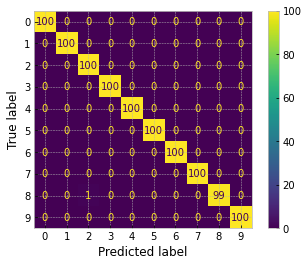

In [118]:
print('Performance of Project 1 classifier w augmented training data, stddev=0.2:')
conf_mx = confusion_matrix(new_labels, y)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
Project1Classifier.evaluate(new_images, new_labels)

In [120]:
for idx, stddev in np.ndenumerate(stddev_vals):
    new_images, new_labels = generate_images(codings, labels, stddev, decoder)
    accuracy[idx,:] = Project1Classifier.evaluate(new_images, new_labels)

32/32 [==============================] - 0s 586us/step - loss: 4.3625 - accuracy: 0.2310


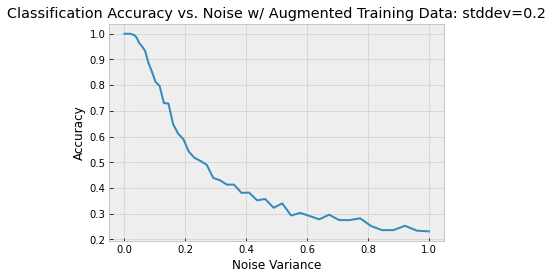

In [121]:
plt.figure()
plt.plot(stddev_vals**2, accuracy[:,1])
plt.xlabel('Noise Variance')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy vs. Noise w/ Augmented Training Data: stddev=0.2');

### Training with Even Noisier Data

In [122]:
new_images, new_labels = generate_images(codings, labels, 0.5, decoder)

In [123]:
noisy_train = np.vstack((X_train, new_images))
noisy_labels = np.hstack((t_train, new_labels))

In [124]:
noisy_train, noisy_val, noisy_labels, noisy_val_labels = train_test_split(noisy_train, noisy_labels, 
                                                  test_size = 0.20,
                                                  stratify = noisy_labels,
                                                  random_state = 0)

In [ ]:
Project1Classifier = models.Sequential([
    layers.Input(shape=(28,28)),
    layers.Flatten(),
    layers.Dense(256, activation = 'sigmoid'),
    layers.Dense(10, activation = 'sigmoid')
])

Project1Classifier.compile(loss = 'sparse_categorical_crossentropy',
         optimizer = optimizer,
         metrics = ['accuracy'])

history = Project1Classifier.fit(noisy_train, noisy_labels, epochs = 500,
                    batch_size = 1024,
                    validation_data = (noisy_val, noisy_val_labels),
                    callbacks = [callback])

Epoch 1/500
39/39 [==============================] - 1s 7ms/step - loss: 0.9298 - accuracy: 0.7212 - val_loss: 0.6176 - val_accuracy: 0.8159
Epoch 2/500
39/39 [==============================] - 0s 5ms/step - loss: 0.5460 - accuracy: 0.8368 - val_loss: 0.5120 - val_accuracy: 0.8476
Epoch 3/500
39/39 [==============================] - 0s 5ms/step - loss: 0.4640 - accuracy: 0.8621 - val_loss: 0.4529 - val_accuracy: 0.8649
Epoch 4/500
39/39 [==============================] - 0s 5ms/step - loss: 0.4096 - accuracy: 0.8801 - val_loss: 0.4132 - val_accuracy: 0.8787
Epoch 5/500
39/39 [==============================] - 0s 5ms/step - loss: 0.3695 - accuracy: 0.8907 - val_loss: 0.3842 - val_accuracy: 0.8874
Epoch 6/500
39/39 [==============================] - 0s 5ms/step - loss: 0.3383 - accuracy: 0.9008 - val_loss: 0.3598 - val_accuracy: 0.8951
Epoch 7/500
39/39 [==============================] - 0s 5ms/step - loss: 0.3127 - accuracy: 0.9094 - val_loss: 0.3403 - val_accuracy: 0.9009
Epoch 8/500
3

In [126]:
y_proba = Project1Classifier.predict(new_images)
y = np.argmax(y_proba, axis=1)

Performance of Project 1 classifier w augmented training data: stddev=0.5
32/32 [==============================] - 0s 594us/step - loss: 0.2381 - accuracy: 0.9390


[0.23809069395065308, 0.9390000104904175]

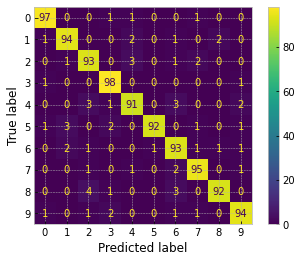

In [127]:
print('Performance of Project 1 classifier w augmented training data: stddev=0.5')
conf_mx = confusion_matrix(new_labels, y)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
Project1Classifier.evaluate(new_images, new_labels)

In [128]:
for idx, stddev in np.ndenumerate(stddev_vals):
    new_images, new_labels = generate_images(codings, labels, stddev, decoder)
    accuracy[idx,:] = Project1Classifier.evaluate(new_images, new_labels)

32/32 [==============================] - 0s 602us/step - loss: 3.5024 - accuracy: 0.2910


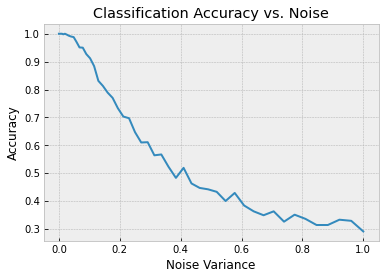

In [129]:
plt.figure()
plt.plot(stddev_vals**2, accuracy[:,1])
plt.xlabel('Noise Variance')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy vs. Noise');

# Custom Loss Function
There are many possible loss functions for classification. However, for this project we have been given the template of using a distance formulation as such: $ R = 1/K\sum_{i=1}^{K} d_i $. We can make modifications to the lambda value that we multiply by R, the distance metric, the batch size K, and other implementation criteria. We will try euclidean distance (with latent space normalization), as well as a Manhattan block distance, and Chebyshev distances.

In [6]:
# custom SAE loss
from sklearn.preprocessing import StandardScaler

class StackedAutoencoderLoss:
    # (tf.keras.losses.Loss)
    def __init__(self, lam=0.5, name="stacked_autoencoder_loss", distance_type = 'l2', prior_dir='sparse'):
        """
        Initialize the loss class.

        Args:
            lam (float): Weighting factor for the custom latent space loss component.
            name (str): Name of the loss.
            distance_type (str): one of 'l1', 'l2', or 'linf' describing the three distance types
            prior_dir (str): either 'sparse' for a sparse encoding or 'dense' for a Gram Schmidt dense matrix
        """
        # super().__init__(name=name)
        self.lam = lam
        self.distance_type = distance_type
        self.prior_dir = prior_dir
        

    def __call__(self, y_true, y_pred, latent_space=None, prior=None):
        if prior is None:
            raise ValueError("Prior argument is required.")
        
        if latent_space is None:
            raise ValueError("Latent space argument is required.")
        """
        Compute the combined loss.

        Args:
            y_true (Tensor): Tensor of true input values for reconstruction (e.g., autoencoder input).
            y_pred (Tensor): Tensor of reconstructed values (autoencoder output).
            latent_space (Tensor): Tensor representing the latent space embeddings.
            prior (Int): Integer of the for the input's class.
         

        Returns:
            A scalar Tensor representing the combined loss value.
        """
        # print(f"y_true shape: {y_true.shape}")
        # print(f"y_pred shape: {y_pred.shape}")
        # print(f"latent_space shape: {latent_space.shape}")
        # print(f"prior shape: {prior.shape}")
        
        # Get batch size
        batch_size = tf.shape(y_true)[0]
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Get latent_space and prior length
        latent_dim = latent_space.shape[-1]
        num_classes = 10
        
        # Reconstruction loss (MSE) across all elements in the batch
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred), axis=(1, 2))  # Adjust axes for your data shape

        # Make prior direction
        if self.prior_dir == 'sparse':
            prior_directions = self.generate_orthogonal_directions(num_classes, latent_dim)
            
        elif self.prior_dir == 'dense':
            prior_directions = self.generate_dense_orthogonal_directions(num_classes, latent_dim)
            
        else:
            raise ValueError("Prior direction may only be 'dense' or 'sparse'.")
        
        # Get the distance measure
        # selected_prior_direction = prior_directions[prior, :]
        prior_casted = tf.cast(prior, tf.int32)
        selected_prior_direction = tf.gather(prior_directions, prior_casted, axis=0)
        
        latent_space_casted = tf.cast(latent_space, tf.float32)
        selected_prior_direction_casted = tf.cast(selected_prior_direction, tf.float32)

        # Compute latent space distance based on the specified metric
        if self.distance_type == 'l1':
            # L1 distance: Sum of absolute differences
            latent_loss = tf.reduce_mean(tf.abs(latent_space_casted - selected_prior_direction_casted), axis=1)
        elif self.distance_type == 'l2':
            # L2 distance: Euclidean distance (squared differences)
            latent_loss = tf.reduce_mean(tf.square(latent_space_casted - selected_prior_direction_casted), axis=1)
        elif self.distance_type == 'linf':
            # Linf distance: Maximum absolute difference
            latent_loss = tf.reduce_max(tf.abs(latent_space_casted - selected_prior_direction_casted), axis=1)
        else:
            raise ValueError("Distance type must be 'l1', 'l2', or 'linf'.")
        

        # Latent space loss (e.g., L2 distance to prior)
        latent_loss = latent_loss / tf.cast(batch_size, tf.float32)
        
        mse_loss = tf.reduce_mean(mse_loss)  # Reduce to a scalar
        latent_loss = tf.reduce_mean(latent_loss) 

        # Combine both losses per sample in the batch
        total_loss = (self.lam * mse_loss) + ((1- self.lam) * latent_loss)

        # Average over the batch
        return tf.reduce_mean(total_loss)
    
    def generate_dense_orthogonal_directions(self, num_classes, latent_dim, seed=10):
        """
        Generate dense orthogonal target directions using Gram-Schmidt process.

        Args:
            num_classes (int): Number of classes.
            latent_dim (int): Dimensionality of the latent space.

        Returns:
            np.ndarray: Array of shape (num_classes, latent_dim) containing dense orthogonal unit vectors.
        """
        if num_classes > latent_dim:
            raise ValueError("Number of classes cannot exceed latent space dimensionality.")

        np.random.seed(seed)
        # Start with random vectors
        random_vectors = np.random.randn(num_classes, latent_dim)

        # Apply Gram-Schmidt process to orthogonalize
        orthogonal_vectors = []
        for v in random_vectors:
            for u in orthogonal_vectors:
                v -= np.dot(v, u) * u  # Subtract projection
            v = v / np.linalg.norm(v)  # Normalize
            orthogonal_vectors.append(v)
        
        return np.array(orthogonal_vectors)
    
    def generate_orthogonal_directions(self, num_classes, latent_dim):
        """
        Generate orthogonal target directions in latent space.

        Args:
            num_classes (int): Number of classes.
            latent_dim (int): Dimensionality of the latent space.

        Returns:
            np.ndarray: Array of shape (num_classes, latent_dim) containing orthogonal unit vectors.
        """
        if num_classes > latent_dim:
            raise ValueError("Number of classes cannot exceed latent space dimensionality.")

        # Start with an identity matrix for orthogonal vectors
        identity_matrix = np.eye(latent_dim)

        # Select the first num_classes rows
        target_directions = identity_matrix[:num_classes]

        return target_directions
    

# Create train and test functions

In [9]:
############################# Training Functions ###########################################

# Custom Training Step
@tf.function
def train_step(x, class_labels, model, loss_fn, optimizer):
    with tf.GradientTape() as tape:
        y_pred, latent_space = model(x)  # Forward pass
        # Check if y_pred or latent_space is a tuple
        class_labels = tf.reshape(class_labels, (-1, 1))
        
        # print(f"x shape: {x.shape}")
        # print(f"class_labels shape: {class_labels.shape}")
        # print(f"y_pred shape: {y_pred.shape}")
        # print(f"latent_space shape: {latent_space.shape}")
        
        # Pass class_labels as prior to the loss function
        loss_value = loss_fn(x, y_pred, latent_space, class_labels)  # Corrected call to loss_fn with 4 arguments
    grads = tape.gradient(loss_value, model.trainable_variables)  # Compute gradients
    optimizer.apply_gradients(zip(grads, model.trainable_variables))  # Apply gradients
    return loss_value



# Training Loop with validation loss tracking
def train(train_dataset, val_dataset, epochs, model, optimizer, loss_fn, verbose=True):
    best_val_loss = float('inf')  # Track the best validation loss
    for epoch in range(epochs):
        if verbose == True:
            print(f"Epoch {epoch+1}/{epochs}")
        
        # Store all the training losses
        avg_trn_loss = np.zeros(epochs)
        # Training phase
        trn_loss = 0
        for x_batch, class_labels in train_dataset:
            loss_value = train_step(x_batch, class_labels, model, loss_fn, optimizer)  # Train step
            trn_loss += loss_value
            # print(f"Training Loss: {loss_value.numpy()}")
        avg_trn_loss[epoch] = trn_loss/len(train_dataset)
        
        
        # Validation phase (compute the validation loss)
        val_loss = 0
        for x_batch_val, class_labels_val in val_dataset:
            y_pred_val, latent_space_val = model(x_batch_val)  # Forward pass
            val_loss += loss_fn(x_batch_val, y_pred_val, latent_space_val, class_labels_val).numpy()
        
        # Calculate average validation loss over the validation dataset
        val_loss /= len(val_dataset)
        
        if verbose==True:
            print(f"Training Loss: {trn_loss/len(train_dataset)}")
            print(f"Validation Loss: {val_loss}")
        
        # Save the best model weights based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model.set_weights(model.get_weights())  # Save the best model weights
            if verbose == True:
                print("Best model weights saved!")

    print("Training completed!")
    
    return avg_trn_loss, best_val_loss, model

class CustomAutoencoder(tf.keras.Model):
    def __init__(self, encoder, decoder, loss_fn):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.loss_fn = loss_fn

    def call(self, x):
        latent_space = self.encoder(x)
        y_pred = self.decoder(latent_space)
        return y_pred, latent_space


################################## Testing Functions #################################################
def test_step(x, class_labels, model, classifier):
    y_pred, latent_space = model(x, training=False)  # Forward pass in eval mode
    # loss_value = loss_fn(x, y_pred, latent_space, class_labels)  # Compute loss
    test_loss, test_accuracy = classifier.evaluate(y_pred, class_labels)
    return test_loss, test_accuracy

# Full Evaluation Function
def evaluate(test_dataset, model, classifier, verbose=True):
    total_loss = 0
    total_accuracy = 0

    for x_batch, class_labels in test_dataset:
        loss_value, accuracy_value = test_step(x_batch, class_labels, model, classifier)
        total_loss += loss_value.numpy()  # Accumulate loss
        total_accuracy += accuracy_value.numpy()

    # Calculate average loss over the test dataset
    avg_loss = total_loss / len(test_dataset)
    avg_accuracy = total_accuracy / len(test_dataset)

    if verbose:
        print(f"Average Classifier Loss: {avg_loss}")
        print(f"Average Classifier Accuracy: {avg_accuracy}")

    # Optionally return additional info for further analysis
    return avg_loss, avg_accuracy

# Test quality of loss function and search over grid space of batch size (K) and lambda value weights

In [8]:
callback = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 10,
                                         restore_best_weights = True)

optimizer = optimizers.Nadam(learning_rate = 0.001, 
                                   beta_1 = 0.9, beta_2 = 0.999)

Project1Classifier = models.Sequential([
    layers.Input(shape=(28,28)),
    layers.Flatten(),
    layers.Dense(256, activation = 'sigmoid'),
    layers.Dense(10, activation = 'sigmoid')
])

Project1Classifier.compile(loss = 'sparse_categorical_crossentropy',
         optimizer = optimizer,
         metrics = ['accuracy'])

history = Project1Classifier.fit(X_train, t_train, epochs = 500,
                    batch_size = 1024,
                    validation_data = (X_val, t_val),
                    callbacks = [callback],
                    verbose=0)

In [ ]:
from tensorflow.keras import datasets, layers, models, optimizers, losses, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint


# Set SAE bottleneck to 10 just to check hyperparameter space and test the loss function
bottleneckNum  = 10
lr = 0.0005
B1 = 0.875
B2 = 0.997

################################## Build the Model ###########################################

encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneckNum,  activation='relu', use_bias=False)
        ])

decoder = models.Sequential([
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(28*28, use_bias=False),
            layers.Reshape([28, 28])
])


# Optimizer can be set once; use same values as best previously
optimizer = optimizers.Adam(learning_rate=lr, beta_1=B1, beta_2=B2)


# Set up grid parameters
batch_k = np.array([1,2,4,16,32,64])
lam = np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9])

test_acc_all = np.zeros((len(batch_k), len(lam)))
test_loss_all = np.zeros((len(batch_k), len(lam)))

# Make a dataset loader:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, t_train))  # Pair images with labels
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, t_val))  # Pair images with labels

for ii in range(len(batch_k)):
    
    # Set up the dataset
    train_dataset = train_dataset.batch(batch_k[ii]).shuffle(buffer_size=1000)
    val_dataset = val_dataset.batch(batch_k[ii])
    
    for jj in range(len(lam)):
        # Start training with validation loss tracking
        # Set up loss
        loss_fn = StackedAutoencoderLoss(lam=lam[jj], distance_type = 'l2', prior_dir='dense')
        
        # Create the autoencoder with encoder, decoder
        autoencoder_model = CustomAutoencoder(encoder, decoder, loss_fn)
        
        train_history, best_val_loss = train(train_dataset, val_dataset, epochs=100, model=autoencoder_model, optimizer=optimizer, loss_fn=loss_fn, verbose = False)
        test_loss_all[ii,jj], test_acc_all[ii,jj] = evaluate(train_dataset,  model=autoencoder_model, classifier=Project1Classifier, verbose=False)
        
        

        